In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from numpy.linalg import inv
from gaussian_processes_util import plot_gp,plot_gp_2D
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

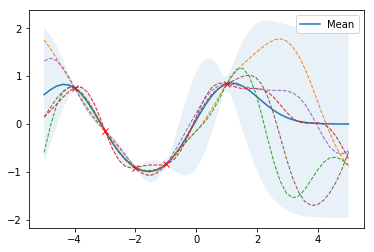

In [5]:



def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f) 
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (15.15) p.520 murphy
    mu_s = K_s.T @ K_inv @ Y_train
    # Equation (15.16)
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

# Noiseless training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
Y_train = np.sin(X_train)
n=50
X_s = np.linspace(-5,5,n).reshape(-1,1)

mu_s, cov_s = posterior_predictive(X_s,X_train,Y_train)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)
plot_gp(mu_s, cov_s, X_s, X_train=X_train, Y_train=Y_train, samples=samples, label=False)

In [14]:
import pandas as pd
datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_max_labeled_df_23.csv'

df = pd.read_csv(datapath)
print ('there are {} unique farms in loaded df'.format(pd.unique(df.pixel).size))
df_unique =  df.set_index('pixel')
df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index value

there are 164 unique farms in loaded df


In [106]:
%matplotlib notebook

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    f = plt.subplots(figsize=(8,4))
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap='coolwarm', linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap='coolwarm')
    ax.set_title(title)

<IPython.core.display.Javascript object>


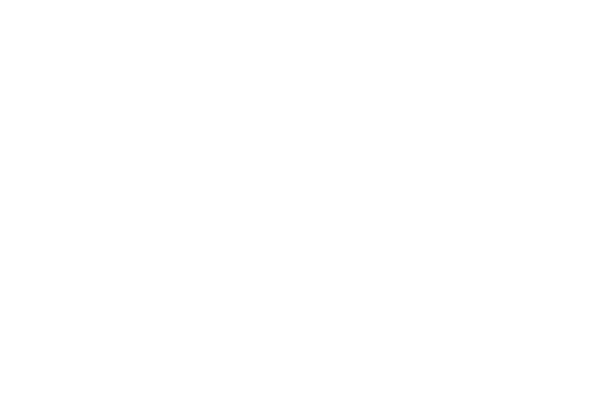

((100, 100),
 (100, 100),
 (100, 100),
 <bound method Figure.add_subplot of <Figure size 432x288 with 0 Axes>>)

In [107]:
gridx.shape,gridy.shape,mu_s.reshape(gridx.shape).shape, plt.gcf().add_subplot

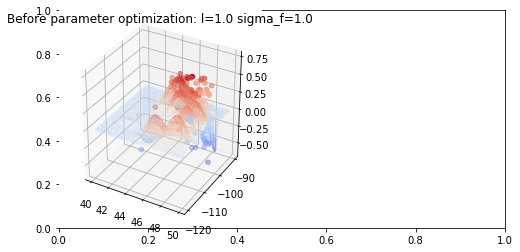

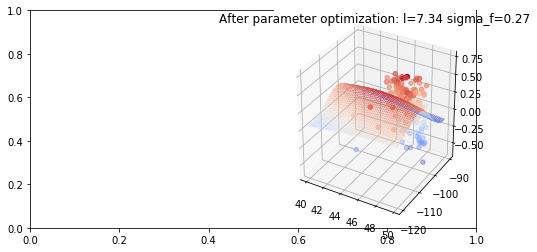

In [147]:
# ========= train points =========
X_2D_train = np.vstack((df_unique.Latitude,df_unique.Longitude)).T
Y_2D_train = np.array(df_unique.Bp_zprsum3)
sigma_y = .5

# ======= new test points ========
arrayx, arrayy = np.arange(40, 50, 0.1), np.arange(-120, -90, .3)
gridx, gridy = np.meshgrid(arrayx, arrayy)
X_2D = np.c_[gridx.ravel(), gridy.ravel()]

mu_s_nonopt, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=sigma_y)
plot_gp_2D(gridx, gridy, mu_s_nonopt, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, sigma_y), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=sigma_y)
plot_gp_2D(gridx, gridy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)
           

In [127]:
rx.shape, ry.shape, gridx.shape, gridy.shape, X_2D.shape, Y_2D_train.shape, mu_s.shape

((34,), (34,), (100, 100), (100, 100), (10000, 2), (164,), (10000,))

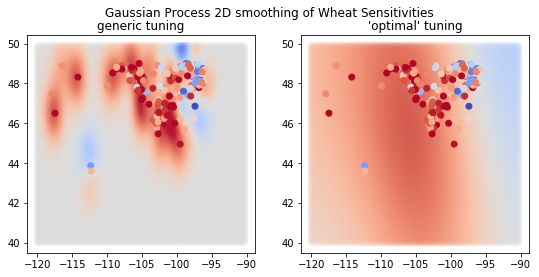

In [161]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,4))
fig.suptitle('Gaussian Process 2D smoothing of Wheat Sensitivities')
ax1.scatter(np.ravel(gridy),np.ravel(gridx),c=mu_s_nonopt, cmap='coolwarm', vmin=-.5,vmax=.5, alpha=.2);
ax1.scatter(X_2D_train[:,1],X_2D_train[:,0], c=Y_2D_train,cmap='coolwarm',vmin=-.5,vmax=.5, alpha=1)
ax1.set_title('generic tuning')
ax2.scatter(np.ravel(gridy),np.ravel(gridx),c=mu_s, cmap='coolwarm', vmin=-.5,vmax=.5, alpha=.2);
ax2.scatter(X_2D_train[:,1],X_2D_train[:,0], c=Y_2D_train,cmap='coolwarm',vmin=-.5,vmax=.5, alpha=1);
ax2.set_title("'optimal' tuning");

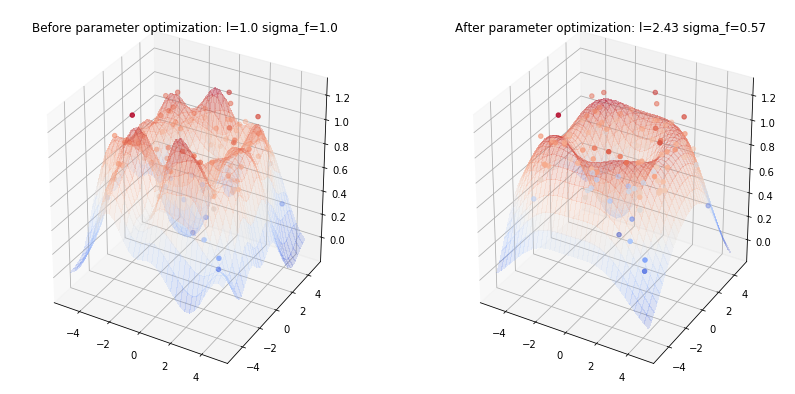

In [71]:

from gaussian_processes_util import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

In [72]:
rx.shape, ry.shape, gx.shape, gy.shape, X_2D.shape, Y_2D_train.shape

((34,), (34,), (34, 34), (34, 34), (1156, 2), (100,))

In [47]:
def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable
